In [15]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [16]:
COLS = ["CorsikaId","px","py","pz","xprime","yprime","t",
        "shower_id","prm_id","prm_energy","prm_theta","prm_phi"]

## Creating a function to do the data wrangling for all the data sets

In [17]:
def wrangle(file_path):
    df = pd.read_csv(file_path, # path
                 comment="#", # ignore comments
                 sep=' ',# separation is space
                 header=None, # no other header set
                 names=COLS, # the name of the columns
                 engine="python" 
    )
    # subsetting the data for only muons and resetting the index
    muons = (df["CorsikaId"] == 5) | (df["CorsikaId"] == 6)
    df = df[muons].reset_index()

    # computing the zenith angle in radians
    df['p'] = np.sqrt(df['px']**2 + df['py']**2 + df['pz']**2)
    df['theta_rad'] = np.arccos(df['pz'] / df['p'])  # zenith angle in radians 

    # theta radians in degrees
    df['theta'] = np.rad2deg(df['theta_rad'])


    return df


In [18]:
chyulu = wrangle("../chyulu_1500m_15/salida.shw")
chyulu.head()

,index,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,2,5,0.185975,-1.838230,1.737850,-2693.500,-6053.16,952.556,2,703,99.0012,40.678,-72.955,2.536493,0.816002,46.753478
1,5,6,0.025138,0.227154,0.276715,1431.550,-11383.50,945.671,5,1105,55.9122,39.475,78.289,0.358890,0.690339,39.553526
2,17,6,14.985200,10.651100,4.385750,-456.529,-6288.62,952.881,9,1206,1068.2900,75.565,36.869,18.900713,1.336620,76.582706
3,18,5,2.229520,1.574890,0.938240,-12470.100,-13370.30,929.772,9,1206,1068.2900,75.565,36.869,2.886405,1.239727,71.031099
4,19,5,-0.267935,-0.057037,0.456278,-1887.370,-2374.27,955.278,10,1206,85.7951,41.574,-164.857,0.532195,0.540697,30.979629


In [19]:
lyon = wrangle("../lyon_237m_15/salida.shw")
lyon.head()

,index,CorsikaId,px,py,pz,xprime,yprime,t,shower_id,prm_id,prm_energy,prm_theta,prm_phi,p,theta_rad,theta
0,6,6,1.217480,-2.586510,5.145480,1691.920,-890.006,955.713,1,703,557.786,27.053,-69.324,5.886277,0.507117,29.055642
1,7,6,0.798836,-2.311930,4.144450,1681.200,-3426.750,954.857,1,703,557.786,27.053,-69.324,4.812445,0.533182,30.549057
2,8,6,0.177550,-0.500619,1.459960,-23.547,530.579,955.978,1,703,557.786,27.053,-69.324,1.553585,0.348939,19.992713
3,13,5,0.370895,-0.628453,1.178630,1742.590,-1894.570,955.480,1,703,557.786,27.053,-69.324,1.386249,0.554374,31.763312
4,14,5,0.232539,-0.615888,0.946762,1107.490,-2911.370,955.239,1,703,557.786,27.053,-69.324,1.153148,0.607594,34.812596


Comparing the graphs

In [20]:
def cos_squared_model(theta_deg, I0):
    """Cosine-power model with n fixed at 3: I(theta) = I0 * cos^2(theta)"""
    theta_rad = np.deg2rad(theta_deg)
    return I0 * np.cos(theta_rad)**2

In [21]:
# generating 100 values from 0 to 90 
theta_range = np.linspace(0, 90, 100)
 # binning the zenith angle
bins = np.arange(0, 91, 10)

Fitted I0 with n=3: 73.007 (in arbitrary units)
Fitted I0 with n=3: 55.347 (in arbitrary units)


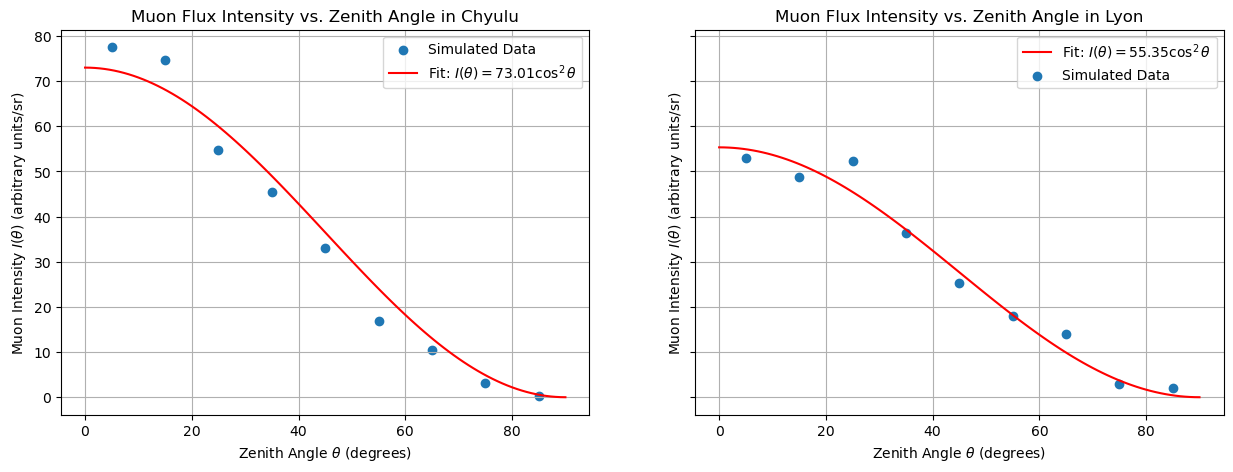

In [22]:
# creating the 3 plots in one row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True, sharex=True)

# zenith angles for chyulu
counts, bin_edges = np.histogram(chyulu['theta'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

# calculating solid angle
bin_edges_rad = np.deg2rad(bin_edges) 
solid_angles = 2 * np.pi * (np.cos(bin_edges_rad[:-1]) - np.cos(bin_edges_rad[1:]))

# calculating flux intensity (input how long the simulation was running)
time = float(input("How long did the simulation run in Chyulu(s): "))
flux_intensity = counts / time / solid_angles



# fitting the binned data
try:
    popt, pcov = curve_fit(cos_squared_model, bin_centers, flux_intensity, p0=[1.0])
    I0_fit = popt[0]
    print(f"Fitted I0 with n=3: {I0_fit:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit = 1.0 # Default value if fit fails

# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit)

# Plot the binned data points (flux vs zenith angle)
axes[0].scatter(bin_centers, flux_intensity, label='Simulated Data')


#plotting the curve on the same plot as 
axes[0].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit:.2f} \\cos^2\\theta$')


# plotting the graph
axes[0].set_title('Muon Flux Intensity vs. Zenith Angle in Chyulu')
axes[0].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[0].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[0].legend()
axes[0].grid(True)

# ------------------------------------------------------------------------------

# zenith angles for lyon
counts_chyulu, bin_edges_chyulu = np.histogram(lyon['theta'], bins=bins)
bin_centers_chyulu = (bin_edges_chyulu[:-1] + bin_edges_chyulu[1:]) / 2.0

# calculating solid angle
bin_edges_rad_c = np.deg2rad(bin_edges_chyulu) 
solid_angles_chyulu = 2 * np.pi * (np.cos(bin_edges_rad_c[:-1]) - np.cos(bin_edges_rad_c[1:]))

# calculating flux intensity (input how long the simulation was running)
time_chyulu = float(input("How long did the simulation run in lyon(s): "))
flux_intensity_chyulu = counts_chyulu / time_chyulu / solid_angles_chyulu

# fitting the binned data
try:
    popt_chyulu, pcov_chyulu = curve_fit(cos_squared_model, bin_centers_chyulu, flux_intensity_chyulu, p0=[1.0])
    I0_fit_chyulu = popt_chyulu[0]
    print(f"Fitted I0 with n=3: {I0_fit_chyulu:.3f} (in arbitrary units)")
except RuntimeError as e:
    print(f"Could not fit the curve: {e}")
    I0_fit_chyulu = 1.0 # Default value if fit fails


# fitting the curve with generated data 
fitted_curve = cos_squared_model(theta_range, I0_fit_chyulu)


#plotting the curve on the same plot as 
axes[1].plot(theta_range, fitted_curve, 'r-', label=f'Fit: $I(\\theta) = {I0_fit_chyulu:.2f} \\cos^2\\theta$')

# Plot the binned data points (flux vs zenith angle)
axes[1].scatter(bin_centers_chyulu, flux_intensity_chyulu, label='Simulated Data')


# plotting the graph
axes[1].set_title('Muon Flux Intensity vs. Zenith Angle in Lyon')
axes[1].set_xlabel('Zenith Angle $\\theta$ (degrees)')
axes[1].set_ylabel('Muon Intensity $I(\\theta)$ (arbitrary units/sr)')
axes[1].legend()
axes[1].grid(True)

# Print all graphs
plt.tight_layout
plt.show()

The difference in Muons in Chyulu and Lyon

In [23]:
print("--Lyon 237m E2 Time 15 secs-- \n")
top_shower_id_lyon = lyon["CorsikaId"].groupby(lyon["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_lyon = len(lyon)
print(f"Total Muon Distribution {muon_distribution_lyon} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_lyon}")

--Lyon 237m E2 Time 15 secs-- 

Total Muon Distribution 1811 

Number  of unique shower ids in 881

 Top ten shower ids in lyon 
 shower_id
93      78
6       78
11      57
10      37
7       28
152     23
1389    22
1112    19
1299    16
500     12
Name: CorsikaId, dtype: int64


In [24]:
print("--Chyulu 1500m E1 Time 15 secs-- \n")
# groupby
top_shower_id_chyulu = chyulu["CorsikaId"].groupby(chyulu["shower_id"]).count().sort_values(ascending=False).head(10)
muon_distribution_chyulu = len(chyulu)
print(f"Total Muon Distribution {muon_distribution_chyulu} \n")
print(f"Number  of unique shower ids in {lyon['shower_id'].nunique()}\n")
print(f" Top ten shower ids in lyon \n {top_shower_id_chyulu}")

--Chyulu 1500m E1 Time 15 secs-- 

Total Muon Distribution 2059 

Number  of unique shower ids in 881

 Top ten shower ids in lyon 
 shower_id
426     59
26      25
1424    22
913     17
1480    17
177     16
166     15
2140    14
259     13
23      12
Name: CorsikaId, dtype: int64


Lyon's (237m Altitude) Muon count is less than Chyulu(1500m Altitude) so we can safely say that our simulation run appropriately to our theoretical knowledge.